In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns # Thêm thư viện này để vẽ tương quan

In [3]:
# 1. Load dữ liệu đã làm sạch từ bước trước
df = pd.read_csv('training_data_final.csv', parse_dates=['Datetime'], index_col='Datetime')

In [16]:
# 2. FEATURE ENGINEERING (ĐÃ BỎ MILK)
# Chỉ giữ lại các yếu tố có khả năng ảnh hưởng tới Vàng
features = ['Gold', 'Silver', 'Brent', 'Wheat', 'USD index'] 
target = 'Gold'

# A. Tạo Lag (Quá khứ)
for col in features:
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_lag2'] = df[col].shift(2)

# B. Tạo Rolling (Xu hướng)
df['Gold_MA5'] = df['Gold'].rolling(window=5).mean().shift(1)
df['Gold_Vol5'] = df['Gold'].rolling(window=5).std().shift(1)

# Xóa NaN
df.dropna(inplace=True)

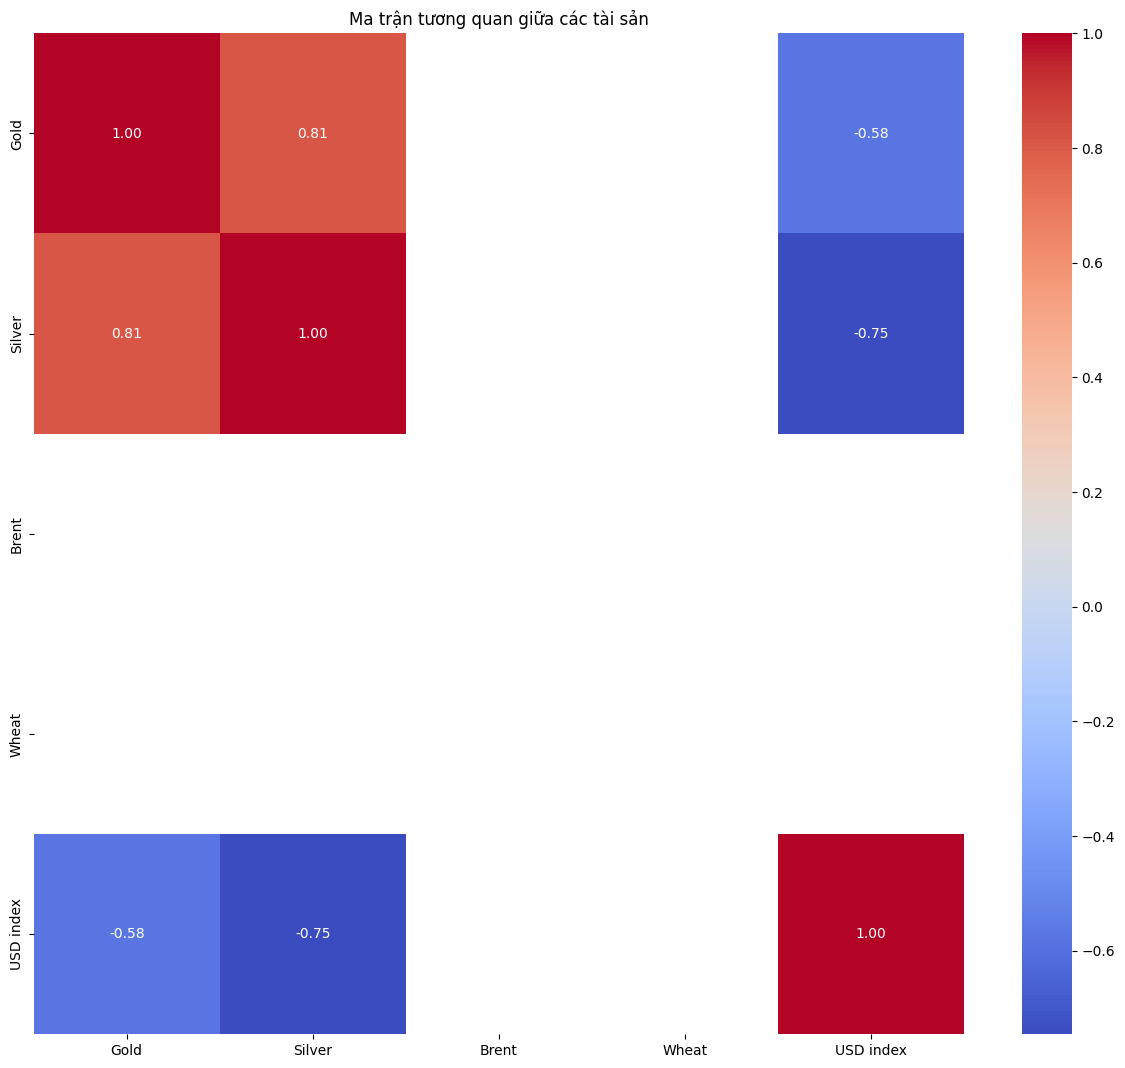

In [9]:
# 3. KIỂM TRA TƯƠNG QUAN (Bước này rất quan trọng để chứng minh Milk là thừa)
import seaborn as sns
plt.figure(figsize=(15, 13))
# Chỉ tính tương quan các cột giá gốc để xem
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa các tài sản")
plt.show()

In [19]:
# 4. CHUẨN BỊ INPUT CHO XGBOOST
# Lấy tất cả cột Lag, MA, Vol làm đầu vào
input_cols = [c for c in df.columns if 'lag' in c or 'MA' in c or 'Vol' in c]
X = df[input_cols]
y = df[target]

# Chia Train/Test (80/20)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [20]:
# 5. TRAIN MODEL
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [21]:
# 6. ĐÁNH GIÁ
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print(f"✅ MAE (Sai số tuyệt đối): {mae:.4f}")
print(f"✅ RMSE (Sai số toàn phương): {rmse:.4f}")

✅ MAE (Sai số tuyệt đối): 0.0158
✅ RMSE (Sai số toàn phương): 0.0166


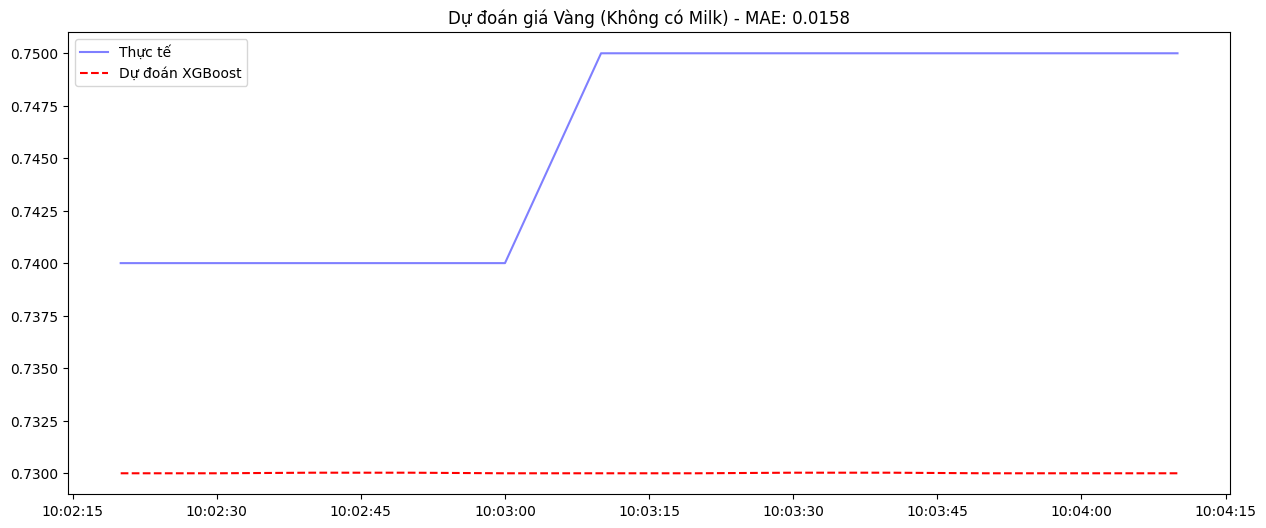

In [22]:
# 7. VẼ KẾT QUẢ
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Thực tế', color='blue', alpha=0.5)
plt.plot(y_test.index, predictions, label='Dự đoán XGBoost', color='red', linestyle='--')
plt.title(f'Dự đoán giá Vàng (Không có Milk) - MAE: {mae:.4f}')
plt.legend()
plt.show()

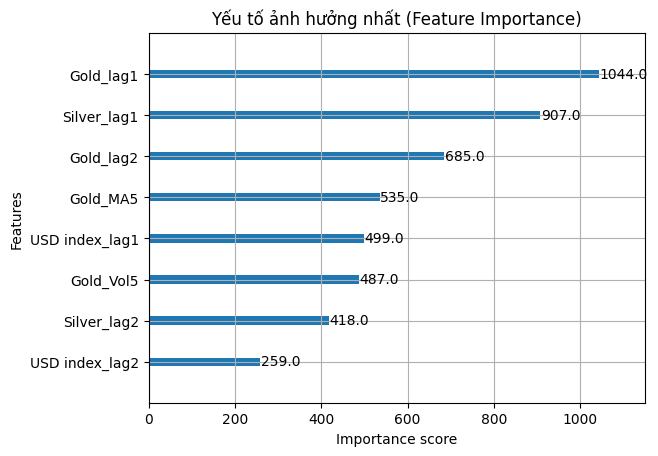

In [23]:
# 8. XEM ĐỘ QUAN TRỌNG
xgb.plot_importance(model, max_num_features=10, importance_type='weight')
plt.title("Yếu tố ảnh hưởng nhất (Feature Importance)")
plt.show()